In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from IPython.display import display

***

## RANdom SAmple Consensus (RANSAC) Algorithm

using simple algorithm, can be improved with advance methods that control the loss function i.e. Huber loss, etc..

 > link to RANSAC = [http://scikit-learn.org/stable/modules/linear_model.html#ransac-regression](http://scikit-learn.org/stable/modules/linear_model.html#ransac-regression)

Each iteration performs the following steps:

1. Select `min_samples` random samples from the original data and check whether the set of data is valid (see `is_data_valid`).

2. Fit a model to the random subset (`base_estimator.fit`) and check whether the estimated model is valid (see `is_model_valid`).

3. Classify all data as inliers or outliers by calculating the residuals to the estimated model (`base_estimator.predict(X) - y`) - all data samples with absolute residuals smaller than the `residual_threshold` are considered as inliers.

4. Save fitted model as best model if number of inlier samples is maximal. In case the current estimated model has the same number of inliers, it is only considered as the best model if it has better score.

### Example: Predicting dividends yield

In [3]:
filename = '../data/Australia.dat'

df = pd.read_csv(filename,delim_whitespace=True,skiprows=(0,1), header=(0))
df.columns = ['Date','Mkt','HighB2M', 'LowB2M','HighE2P', 'LowE2P','HighC2P', 'LowC2P','HighYld','LowYld', 'ZeroYld']
df = df.set_index('Date')
df.head()

,Mkt,HighB2M,LowB2M,HighE2P,LowE2P,HighC2P,LowC2P,HighYld,LowYld,ZeroYld
Date,,,,,,,,,,
197501,19.17,21.66,13.80,16.62,17.59,17.05,15.38,17.34,17.85,19.74
197502,0.52,2.78,-0.71,6.56,-1.86,2.93,-1.87,6.94,-1.46,3.47
197503,-2.04,-0.46,-1.79,2.75,-2.67,-0.33,-2.21,2.22,-2.91,-12.14
197504,-0.28,-1.00,-0.42,2.82,-0.97,-2.27,-1.35,2.64,-0.57,-14.34
197505,9.72,3.65,11.52,10.48,10.30,6.46,9.19,9.51,12.40,1.82


In [4]:
display(df)

,Mkt,HighB2M,LowB2M,HighE2P,LowE2P,HighC2P,LowC2P,HighYld,LowYld,ZeroYld
Date,,,,,,,,,,
197501,19.17,21.66,13.80,16.62,17.59,17.05,15.38,17.34,17.85,19.74
197502,0.52,2.78,-0.71,6.56,-1.86,2.93,-1.87,6.94,-1.46,3.47
197503,-2.04,-0.46,-1.79,2.75,-2.67,-0.33,-2.21,2.22,-2.91,-12.14
197504,-0.28,-1.00,-0.42,2.82,-0.97,-2.27,-1.35,2.64,-0.57,-14.34
197505,9.72,3.65,11.52,10.48,10.30,6.46,9.19,9.51,12.40,1.82
197506,-1.88,-2.13,-4.02,-3.06,-1.13,-3.51,-3.14,-2.39,-1.94,-1.98
197507,-1.78,-3.37,-1.77,-3.01,-1.59,0.71,-2.41,-3.57,-1.35,16.20
197508,-0.70,-0.78,-0.31,1.69,-0.23,-3.04,1.05,1.31,-1.22,-0.68
197509,8.53,14.18,8.51,7.86,7.33,10.59,10.36,9.75,6.05,15.23


In [5]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

dependent_var = 'HighYld'
independent_var = 'LowYld'

regress_df = df.loc[:,[dependent_var, independent_var]]
regress_df - clean_dataset(regress_df)
regress_df.head()

,HighYld,LowYld
Date,,
197501,17.34,17.85
197502,6.94,-1.46
197503,2.22,-2.91
197504,2.64,-0.57
197505,9.51,12.40


In [6]:
X = regress_df[independent_var].values.reshape(-1,1)
y = regress_df[dependent_var].astype(np.float64)


In [7]:
from sklearn.linear_model import RANSACRegressor

ransac = RANSACRegressor()
ransac.fit(X, y)

inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

In [24]:
line_X = np.arange(-60, 30, 1)
line_y_ransac = ransac.predict(line_X.reshape(-1, 1))

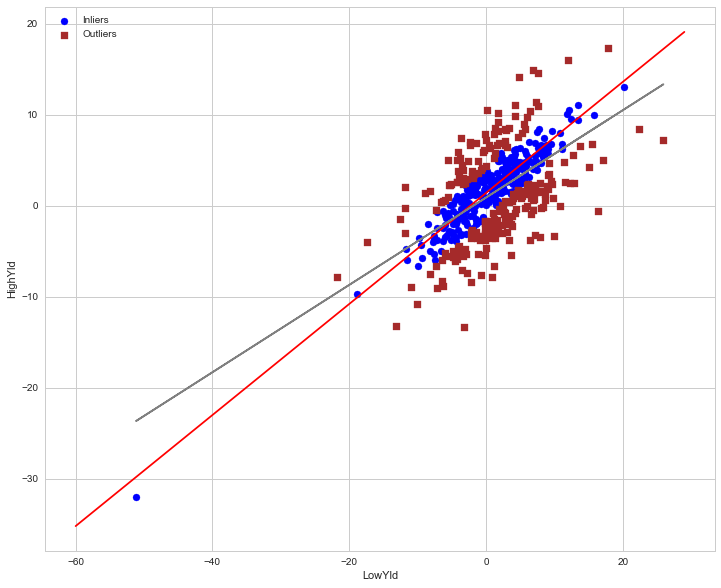

In [26]:
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
plt.figure(figsize=(12,10));
plt.scatter(X[inlier_mask], y[inlier_mask], 
            c='blue', marker='o', label='Inliers')
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='brown', marker='s', label='Outliers')
plt.plot(line_X, line_y_ransac, color='red')
#plt.xlim(0,5)
#plt.ylim(-10, 10)
plt.xlabel(independent_var)
plt.ylabel(dependent_var)
plt.legend(loc='upper left')

# OLS
fit = np.polyfit(X.T.ravel(), y.values, deg=1)
plt.gca().plot(X, fit[0] * X + fit[1], color='grey')

plt.show()

# 5: Correlation Analysis and Feature Selection

In [10]:
pd.options.display.float_format = '{:,.2f}'.format
focus_columns = df.columns

instruments = df[focus_columns]
instruments.corr()

,Mkt,HighB2M,LowB2M,HighE2P,LowE2P,HighC2P,LowC2P,HighYld,LowYld,ZeroYld
Mkt,1.00,0.85,0.94,0.85,0.93,0.83,0.91,0.84,0.93,0.68
HighB2M,0.85,1.00,0.72,0.84,0.74,0.83,0.72,0.85,0.74,0.56
LowB2M,0.94,0.72,1.00,0.73,0.91,0.74,0.90,0.71,0.93,0.67
HighE2P,0.85,0.84,0.73,1.00,0.68,0.83,0.66,0.88,0.70,0.51
LowE2P,0.93,0.74,0.91,0.68,1.00,0.71,0.95,0.67,0.95,0.66
HighC2P,0.83,0.83,0.74,0.83,0.71,1.00,0.68,0.79,0.71,0.57
LowC2P,0.91,0.72,0.90,0.66,0.95,0.68,1.00,0.66,0.94,0.65
HighYld,0.84,0.85,0.71,0.88,0.67,0.79,0.66,1.00,0.65,0.48
LowYld,0.93,0.74,0.93,0.70,0.95,0.71,0.94,0.65,1.00,0.65
ZeroYld,0.68,0.56,0.67,0.51,0.66,0.57,0.65,0.48,0.65,1.00


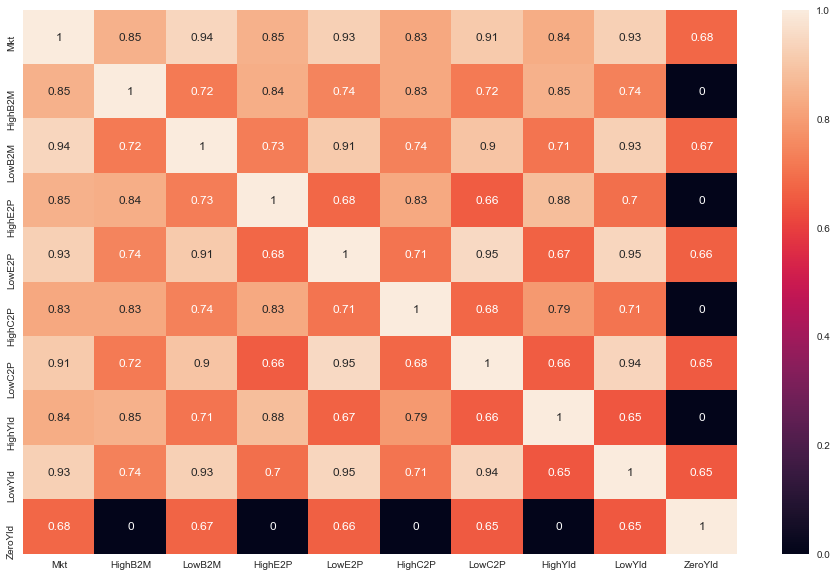

In [11]:
corr_matrix = instruments.corr() 
corr_matrix[np.abs(corr_matrix) < 0.6] = 0

plt.figure(figsize=(16,10))
sns.heatmap(corr_matrix, annot=True)
plt.show()

## Statsmodel

In [12]:
import statsmodels.api as sm
import statsmodels.formula.api as smf


#We need to add a constant term to allow statsmodel.api to calculate the bias / intercepts.
X_constant = sm.add_constant(X)

c:\users\salimn.middleeast\appdata\local\conda\conda\envs\udemy\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [13]:
stats_model = sm.OLS(y, X_constant)
stats_lr = stats_model.fit()

In [14]:
stats_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                HighYld   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.418
Method:                 Least Squares   F-statistic:                     371.5
Date:                Fri, 25 May 2018   Prob (F-statistic):           1.07e-62
Time:                        18:26:08   Log-Likelihood:                -1379.5
No. Observations:                 516   AIC:                             2763.
Df Residuals:                     514   BIC:                             2771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9052      0.157      5.764      0.000       0.597       1.214
x1             0.4796      0.025     19.273      0.000       0.431       0.528
==============================================================================
Omnibus:                        2.837   Durbin-Watson:                   1.743
Prob(Omnibus):                  0.242   Jarque-Bera (JB):                3.062
Skew:                           0.037   Prob(JB):                        0.216
Kurtosis:                       3.370   Cond. No.                         6.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

There are a lot of statistical tests and information. Mostly for the purpose of statistical analysis.

You do not need all of these for data science.

Data science focus is on prediction and having models that work on predicting real data. It is not concerned as much with  correct specifications of statistical problems.

## Detecting Collinearity with Eigenvectors

In [15]:
eigenvalues, eigenvectors = np.linalg.eig(corr_matrix)

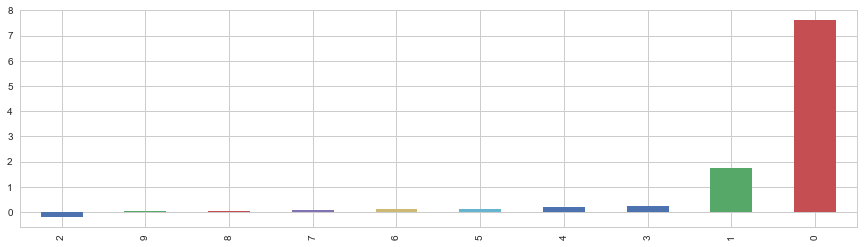

In [16]:
ax = pd.Series(eigenvalues).sort_values().plot.bar(figsize=(15,4))
plt.show()

 > Note that index 4, is near to zero or very small compared to the others. **Small value represents presence of collinearity** 

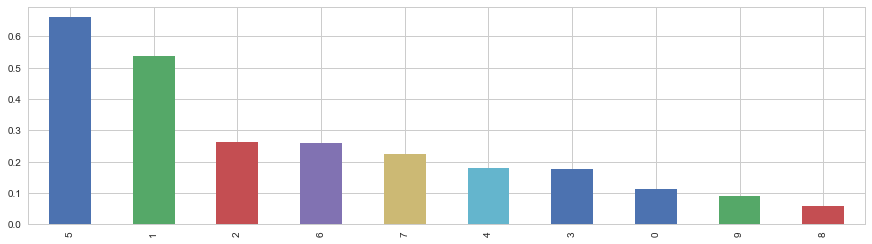

In [17]:
focus_index = np.abs(pd.Series(eigenvectors[:,4])).sort_values(ascending=False)
focus_index.plot.bar(figsize=(15,4))
plt.show()

 > Note that column index 11, 12, 9 have very high loading when compared against the rest

In [18]:
print('Columns causing most multicolinearity: {}'.format( \
    [focus_columns[i] for i in range(len(focus_index[:3].index)) ]))

Columns causing most multicolinearity: ['Mkt', 'HighB2M', 'LowB2M']
